In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [25]:
referral = pd.read_csv('../data/referral.csv')

In [26]:
referral.head()

,provider_npi,entity_type,provider_org_name,provider_last_name,provider_first_name,provider_middle_name,provider_name_prefix,provider_name_suffix,provider_credential,provider_address_1,...,code_group,provider_code_class,code_display_name,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,hospital_name,hospital_code_class
0,1003013160,1.0,NaN,GRABENSTEIN,WILLIAM,P.,DR.,NaN,M.D.,1822 MEMORIAL DR,...,Allopathic & Osteopathic Physicians,Family Medicine,Family Medicine Physician,1104202761,32,55,37.891,39.275,Vanderbilt,Internal Medicine
1,1003013160,1.0,NaN,GRABENSTEIN,WILLIAM,P.,DR.,NaN,M.D.,1822 MEMORIAL DR,...,Allopathic & Osteopathic Physicians,Family Medicine,Family Medicine Physician,1104202761,32,55,37.891,39.275,Vanderbilt,Internal Medicine
2,1003019902,1.0,NaN,ACOSTA,LEALANI,MAE,NaN,NaN,MD,3601 TVC,...,Allopathic & Osteopathic Physicians,Psychiatry & Neurology,Neurology Physician,1104202761,261,406,1.495,9.868,Vanderbilt,Internal Medicine
3,1003050972,1.0,NaN,LENTZ,ROBERT,JAMES,DR.,NaN,M.D.,3601 THE VANDERBILT CLINIC,...,Allopathic & Osteopathic Physicians,Internal Medicine,Pulmonary Disease Physician,1104202761,198,317,0.016,0.202,Vanderbilt,Internal Medicine
4,1003052697,2.0,"SUNCREST HEALTHCARE OF EAST TENNESSEE, LLC",NaN,NaN,NaN,NaN,NaN,NaN,117 E BRYANT ST STE C,...,Agencies,Home Health,Home Health Agency,1104202761,133,182,47.769,57.315,Vanderbilt,Internal Medicine


Seems to be a wide variation in average_day_wait, is that an opportunity to poach?
- calculate total days wait per row (average * transactions)
- use new column in groupby for hospital, specialty etc

In [135]:
# take out Nashville General - the others are large hospital systems while Nashville General is one hospital and typically serves a different population profile
referral = referral.loc[~referral['hospital_name'].isin(['Nashville General'])]

# add total_wait column
referral['total_wait'] = referral['transaction_count'] * referral['average_day_wait']

referral.head()

,provider_npi,entity_type,provider_org_name,provider_last_name,provider_first_name,provider_middle_name,provider_name_prefix,provider_name_suffix,provider_credential,provider_address_1,...,provider_code_class,code_display_name,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,hospital_name,hospital_code_class,total_wait
0,1003013160,1.0,NaN,GRABENSTEIN,WILLIAM,P.,DR.,NaN,M.D.,1822 MEMORIAL DR,...,Family Medicine,Family Medicine Physician,1104202761,32,55,37.891,39.275,Vanderbilt,Internal Medicine,2084.005
1,1003013160,1.0,NaN,GRABENSTEIN,WILLIAM,P.,DR.,NaN,M.D.,1822 MEMORIAL DR,...,Family Medicine,Family Medicine Physician,1104202761,32,55,37.891,39.275,Vanderbilt,Internal Medicine,2084.005
2,1003019902,1.0,NaN,ACOSTA,LEALANI,MAE,NaN,NaN,MD,3601 TVC,...,Psychiatry & Neurology,Neurology Physician,1104202761,261,406,1.495,9.868,Vanderbilt,Internal Medicine,606.970
3,1003050972,1.0,NaN,LENTZ,ROBERT,JAMES,DR.,NaN,M.D.,3601 THE VANDERBILT CLINIC,...,Internal Medicine,Pulmonary Disease Physician,1104202761,198,317,0.016,0.202,Vanderbilt,Internal Medicine,5.072
4,1003052697,2.0,"SUNCREST HEALTHCARE OF EAST TENNESSEE, LLC",NaN,NaN,NaN,NaN,NaN,NaN,117 E BRYANT ST STE C,...,Home Health,Home Health Agency,1104202761,133,182,47.769,57.315,Vanderbilt,Internal Medicine,8693.958


In [136]:
# top level patient stats by hospital system
# add overall average wait to detect difference at the hospital level
top_patient_stats = referral.groupby('hospital_name').agg(total_patients = ('patient_count', 'sum'),
                                                          total_transactions = ('transaction_count', 'sum'),
                                                          total_transaction_wait = ('total_wait', 'sum')).reset_index()

In [141]:
top_patient_stats[['hospital_name', 'total_patients', 'total_transactions']]

,hospital_name,total_patients,total_transactions
0,Ascension St Thomas,1045699,1683036
1,HCA Tristar,1164866,1940550
2,Vanderbilt,2373032,3871413


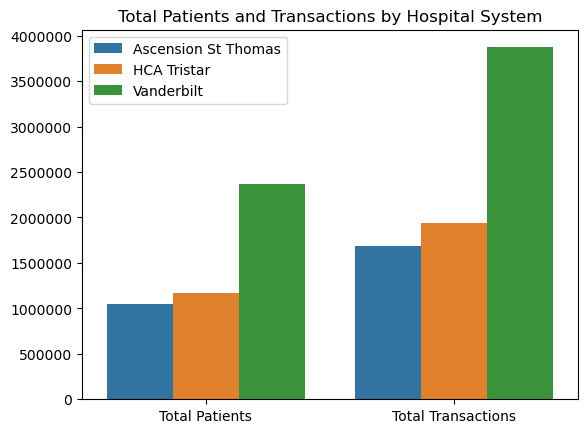

In [143]:
# reshape top patient stats and create grouped barplot

# total patients and transactions by hospital
g = sns.barplot(
    data = top_patient_stats.melt(id_vars = ['hospital_name'], value_vars = ['total_patients', 'total_transactions']),
    y = 'value', x = 'variable', hue = 'hospital_name', errorbar = None)

g.set(xticklabels = ['Total Patients', 'Total Transactions'])
g.set(xlabel = None)
g.set(ylabel = None)
g.set(title = 'Total Patients and Transactions by Hospital System')
g.legend_.set_title(None)

plt.ticklabel_format(style = 'plain', axis = 'y')

plt.savefig('../plots/totals_by_hospital.png');

Two internal NPIs at Vanderbilt account for almost 500k referrals in what appears to be a closed loop. One is internal medicine, the other the actual hospital. This most likely represents hospital internists referring patients to hospital specialties and services and the patients then being referred back. This happens at other hospitals as well, but must hospitals don't directly employ the doctors, but contract through staffing agencies so the individual NPIs would be more likely to have a smaller volume although the end result would be the same. It would be interesting to know whether Vanderbilt's internal referral system functions differently to other hospitals to satisfy red tape requirements or it just doesn't show up as starkly with other hospitals because they're employing more people through agencies rather than directly.

In [144]:
# transaction to patient ratio (my understanding is that patients can have multiple referrals so a higher ratio could indicate potential for larger referral gains with less work)
top_patient_stats['patient_transaction_referral'] = top_patient_stats['total_transactions'] / top_patient_stats['total_patients']

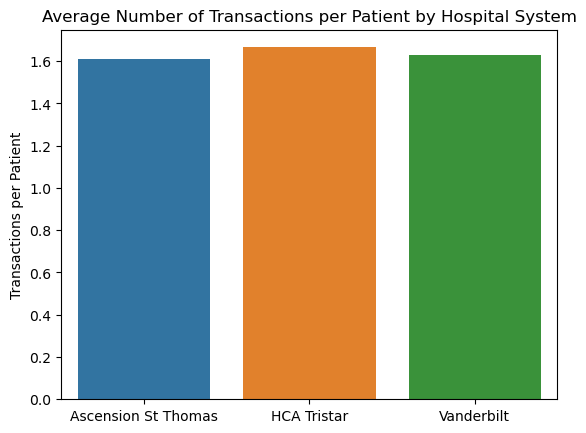

In [148]:
# transactions per patient ratio by hospital
g = sns.barplot(x = 'hospital_name',
            y = 'patient_transaction_referral',
            data = top_patient_stats)

g.set(xlabel = None)
g.set(ylabel = 'Transactions per Patient')
g.set(title = 'Average Number of Transactions per Patient by Hospital System')

plt.savefig('../plots/transaction_ratio.png');

In [150]:
# calculate average wait by hospital
top_patient_stats['avg_hosp_wait'] = top_patient_stats['total_transaction_wait'] / top_patient_stats['total_transactions']

top_patient_stats

,hospital_name,total_patients,total_transactions,total_transaction_wait,patient_transaction_referral,avg_hosp_wait
0,Ascension St Thomas,1045699,1683036,2.517395e+07,1.609484,14.957465
1,HCA Tristar,1164866,1940550,2.713657e+07,1.665900,13.983959
2,Vanderbilt,2373032,3871413,7.487650e+07,1.631420,19.340871


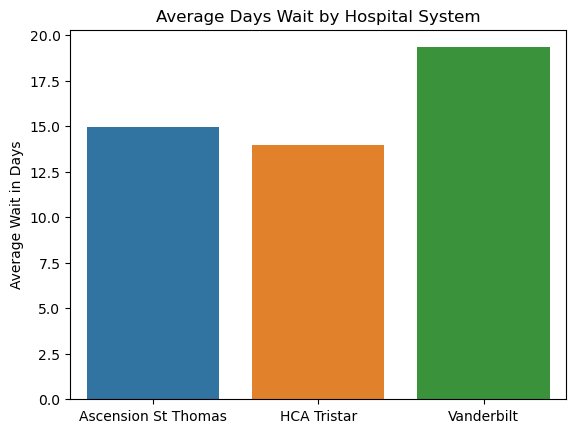

In [152]:
# average days wait by hospital
g = sns.barplot(x = 'hospital_name',
            y = 'avg_hosp_wait',
            data = top_patient_stats)

g.set(xlabel = None)
g.set(ylabel = 'Average Wait in Days')
g.set(title = 'Average Days Wait by Hospital System')

plt.savefig('../plots/avg_wait.png');

In [153]:
# referrals by provider and hospital
# average wait at the provider level could be an indicator of which providers might be more willing to switch (top targets would be most transactions with long wait times)
by_provider = referral.groupby(['hospital_name', 'provider_npi', 'provider_code_class']).agg(total_patients = ('patient_count', 'sum'),
                                                                                             total_transactions = ('transaction_count', 'sum'),
                                                                                             total_transaction_wait = ('total_wait', 'sum')).reset_index()

by_provider['avg_hosp_wait'] = by_provider['total_transaction_wait'] / by_provider['total_transactions']

by_provider

,hospital_name,provider_npi,provider_code_class,total_patients,total_transactions,total_transaction_wait,avg_hosp_wait
0,Ascension St Thomas,1003013160,Family Medicine,66,102,2984.010,29.255000
1,Ascension St Thomas,1003052697,Home Health,957,1371,56198.709,40.991035
2,Ascension St Thomas,1003075862,Family Medicine,138,250,7068.000,28.272000
3,Ascension St Thomas,1003076233,Internal Medicine,319,671,433.280,0.645723
4,Ascension St Thomas,1003112277,Nurse Practitioner,140,198,5707.944,28.828000
...,...,...,...,...,...,...,...
10172,Vanderbilt,1992904049,Psychiatry & Neurology,218,451,374.972,0.831424
10173,Vanderbilt,1992960298,Radiology,150,162,6645.078,41.019000
10174,Vanderbilt,1992972087,Internal Medicine,80,142,4897.048,34.486254
10175,Vanderbilt,1992985055,Specialist,49,61,2650.999,43.459000


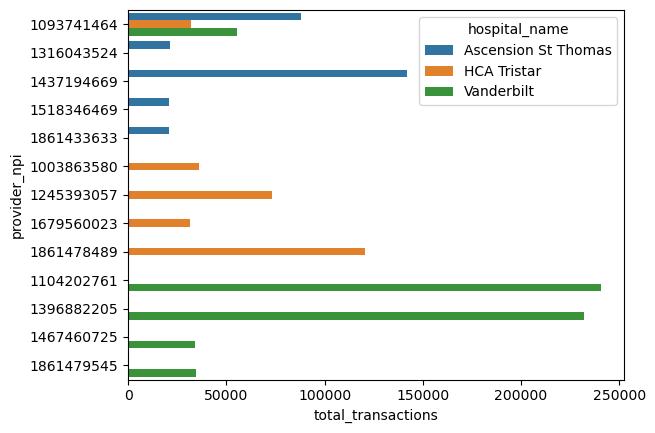

In [154]:
# chart for top 5 referring providers for each hospital system
# partition by_provider by hospital and rank (equivalent in python of course)
# show npi and provider code classification on chart (do I need to concat for this or maybe just have a separate chart)
provider_rank = by_provider.groupby('hospital_name')['total_transactions'].rank(method = 'dense', ascending = False).astype(int).\
                reset_index().drop(columns = 'index').rename({'total_transactions': 'rank'}, axis = 1)

by_provider_rank = pd.merge(by_provider, provider_rank, left_index = True, right_index = True)

top_providers = by_provider_rank.loc[by_provider_rank['rank'] <= 5].copy()
top_providers['provider_npi'] = top_providers['provider_npi'].astype(str)

top_providers
# do these transaction counts make sense?
# Vandy is apparently much better at referring patients to itself than anyone else - top 2 referrers are Vandy hospital NPIs in a referral loop with 500k transactions (pretty evenly divided between the two)
# only one provider makes the top 5 for two hospital systems - NPI 1093741464

# graph showing top 5 providers referring to each hospital
sns.barplot(y = 'provider_npi',
            x = 'total_transactions',
            hue = 'hospital_name',
            data = top_providers);
# formatting: change axis labels, add title, add value number to bars

In [155]:
# 4 providers with 100k+ referrals, one to Ascension (140k), one to HCA (120k), 2 to Vandy (240k and 232k, both from and to Vandy with same NPIs receiving and sending)
top_top_providers = [1437194669, 1861478489, 1104202761, 1396882205]
referral.loc[referral['provider_npi'].isin(top_top_providers)].sort_values('transaction_count', ascending = False)

,provider_npi,entity_type,provider_org_name,provider_last_name,provider_first_name,provider_middle_name,provider_name_prefix,provider_name_suffix,provider_credential,provider_address_1,...,provider_code_class,code_display_name,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,hospital_name,hospital_code_class,total_wait
9037,1104202761,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,1301 22ND AVE S,...,Internal Medicine,Internal Medicine Physician,1396882205,62104,223846,0.832,7.649,Vanderbilt,General Acute Care Hospital,186239.872
2446,1396882205,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,1211 MEDICAL CENTER DRIVE,...,General Acute Care Hospital,General Acute Care Hospital,1104202761,61621,221949,1.120,9.173,Vanderbilt,Internal Medicine,248582.880
6740,1437194669,2.0,SAINT THOMAS MEDICAL PARTNERS,NaN,NaN,NaN,NaN,NaN,NaN,2011 MURPHY AVE,...,Internal Medicine,Internal Medicine Physician,1629025648,13787,52332,3.392,19.494,Ascension St Thomas,General Acute Care Hospital,177510.144
15437,1437194669,2.0,SAINT THOMAS MEDICAL PARTNERS,NaN,NaN,NaN,NaN,NaN,NaN,2011 MURPHY AVE,...,Internal Medicine,Internal Medicine Physician,1164590386,7106,31942,3.132,18.231,Ascension St Thomas,General Acute Care Hospital,100042.344
16307,1437194669,2.0,SAINT THOMAS MEDICAL PARTNERS,NaN,NaN,NaN,NaN,NaN,NaN,2011 MURPHY AVE,...,Internal Medicine,Internal Medicine Physician,1780778969,10661,30880,6.736,26.249,Ascension St Thomas,General Acute Care Hospital,208007.680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20980,1104202761,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,1301 22ND AVE S,...,Internal Medicine,Internal Medicine Physician,1417086596,64,67,36.612,52.234,HCA Tristar,Psychiatric Unit,2453.004
18178,1104202761,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,1301 22ND AVE S,...,Internal Medicine,Internal Medicine Physician,1144748039,38,63,42.968,46.894,Vanderbilt,Clinic/Center,2706.984
21471,1437194669,2.0,SAINT THOMAS MEDICAL PARTNERS,NaN,NaN,NaN,NaN,NaN,NaN,2011 MURPHY AVE,...,Internal Medicine,Internal Medicine Physician,1417915299,36,62,1.984,2.683,Ascension St Thomas,Rehabilitation Unit,123.008
21263,1104202761,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,1301 22ND AVE S,...,Internal Medicine,Internal Medicine Physician,1215979190,59,60,43.217,52.494,Vanderbilt,Rehabilitation Unit,2593.020


In [156]:
# top 5 referrer to Ascension and HCA, classed as internal medicine, org name Advanced Diagnostic Imaging, they also refer to Vandy but do not appear in top 5 (maybe check again if the self-referencing loop gets disqualified)
referral.loc[referral['provider_npi'] == 1093741464].sort_values('transaction_count', ascending = False)

,provider_npi,entity_type,provider_org_name,provider_last_name,provider_first_name,provider_middle_name,provider_name_prefix,provider_name_suffix,provider_credential,provider_address_1,...,provider_code_class,code_display_name,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,hospital_name,hospital_code_class,total_wait
6348,1093741464,2.0,"ADVANCED DIAGNOSTIC IMAGING, PC",NaN,NaN,NaN,NaN,NaN,NaN,3024 BUSINESS PARK CIR,...,Internal Medicine,Internal Medicine Physician,1629025648,14423,36425,5.849,25.153,Ascension St Thomas,General Acute Care Hospital,213049.825
549,1093741464,2.0,"ADVANCED DIAGNOSTIC IMAGING, PC",NaN,NaN,NaN,NaN,NaN,NaN,3024 BUSINESS PARK CIR,...,Internal Medicine,Internal Medicine Physician,1104202761,18068,27180,38.049,50.594,Vanderbilt,Internal Medicine,1034171.820
15971,1093741464,2.0,"ADVANCED DIAGNOSTIC IMAGING, PC",NaN,NaN,NaN,NaN,NaN,NaN,3024 BUSINESS PARK CIR,...,Internal Medicine,Internal Medicine Physician,1780778969,12610,26662,6.346,26.659,Ascension St Thomas,General Acute Care Hospital,169197.052
8998,1093741464,2.0,"ADVANCED DIAGNOSTIC IMAGING, PC",NaN,NaN,NaN,NaN,NaN,NaN,3024 BUSINESS PARK CIR,...,Internal Medicine,Internal Medicine Physician,1396882205,11557,16338,44.296,52.894,Vanderbilt,General Acute Care Hospital,723708.048
13094,1093741464,2.0,"ADVANCED DIAGNOSTIC IMAGING, PC",NaN,NaN,NaN,NaN,NaN,NaN,3024 BUSINESS PARK CIR,...,Internal Medicine,Internal Medicine Physician,1306889597,4401,9776,2.742,17.080,Vanderbilt,General Acute Care Hospital,26805.792
13699,1093741464,2.0,"ADVANCED DIAGNOSTIC IMAGING, PC",NaN,NaN,NaN,NaN,NaN,NaN,3024 BUSINESS PARK CIR,...,Internal Medicine,Internal Medicine Physician,1518346469,4047,9310,2.667,18.856,Ascension St Thomas,General Acute Care Hospital,24829.770
7464,1093741464,2.0,"ADVANCED DIAGNOSTIC IMAGING, PC",NaN,NaN,NaN,NaN,NaN,NaN,3024 BUSINESS PARK CIR,...,Internal Medicine,Internal Medicine Physician,1023055126,6427,9127,42.817,57.291,HCA Tristar,General Acute Care Hospital,390790.759
14409,1093741464,2.0,"ADVANCED DIAGNOSTIC IMAGING, PC",NaN,NaN,NaN,NaN,NaN,NaN,3024 BUSINESS PARK CIR,...,Internal Medicine,Internal Medicine Physician,1982650024,4032,5953,38.595,55.150,HCA Tristar,General Acute Care Hospital,229756.035
17774,1093741464,2.0,"ADVANCED DIAGNOSTIC IMAGING, PC",NaN,NaN,NaN,NaN,NaN,NaN,3024 BUSINESS PARK CIR,...,Internal Medicine,Internal Medicine Physician,1871530832,2025,5077,19.983,42.561,HCA Tristar,General Acute Care Hospital,101453.691
16850,1093741464,2.0,"ADVANCED DIAGNOSTIC IMAGING, PC",NaN,NaN,NaN,NaN,NaN,NaN,3024 BUSINESS PARK CIR,...,Internal Medicine,Internal Medicine Physician,1447571658,2376,4160,32.133,52.143,Ascension St Thomas,General Acute Care Hospital,133673.280


In [174]:
# top specialties referring to each hospital and overall
# do another time (Trey is taking this on for the presentation)

Are there specialties where Vandy 'underperforms' ie has a lower % of referrals than the overall average
- first, what percentage of overall referrals go to Vandy?
- get number of referrals per classification (total across systems)
- group referrals by hospital and classification
- get percentage by hospital and classification

In [190]:
# overall total referrals and percentage by hospital
transaction_percentage = referral.groupby('hospital_name')['transaction_count'].sum().reset_index().rename({'transaction_count': 'hosp_total_transaction_count'}, axis = 1)
transaction_percentage['overall_percentage'] = round(transaction_percentage['hosp_total_transaction_count'] / referral['transaction_count'].sum() * 100, 2)

In [181]:
# total referrals by classification
class_total = referral.groupby('provider_code_class')['transaction_count'].sum().reset_index().rename({'transaction_count': 'class_transaction_count'}, axis = 1)

In [185]:
# referrals by hospital and classification
hosp_class_referral =  referral.groupby(['hospital_name', 'provider_code_class'])['transaction_count'].sum().reset_index().rename({'transaction_count': 'hosp_class_transaction_count'}, axis = 1)

In [203]:
# full dataframe to calculate percentages
ref_hosp_class = pd.merge(hosp_class_referral, class_total)
ref_hosp_class = pd.merge(ref_hosp_class, transaction_percentage)

# percentage for each hospital by class
ref_hosp_class['class_percent'] = round(ref_hosp_class['hosp_class_transaction_count'] / ref_hosp_class['class_transaction_count'] * 100, 2)

# hospital over or under performing by classification compared to overall share of referrals
ref_hosp_class['room_to_grow'] = np.where(ref_hosp_class['overall_percentage'] > ref_hosp_class['class_percent'], True, False)

ref_hosp_class

,hospital_name,provider_code_class,hosp_class_transaction_count,class_transaction_count,hosp_total_transaction_count,overall_percentage,class_percent,room_to_grow
0,Ascension St Thomas,Allergy & Immunology,120,9249,1683036,22.46,1.30,True
1,Ascension St Thomas,Ambulance,47153,130089,1683036,22.46,36.25,False
2,Ascension St Thomas,Anesthesiologist Assistant,88,88,1683036,22.46,100.00,False
3,Ascension St Thomas,Anesthesiology,63271,172129,1683036,22.46,36.76,False
4,Ascension St Thomas,Chiropractor,1048,8340,1683036,22.46,12.57,True
...,...,...,...,...,...,...,...,...
198,Vanderbilt,Clinical Pharmacology,291,291,3871413,51.65,100.00,False
199,Vanderbilt,"Day Training, Developmentally Disabled Services",426,426,3871413,51.65,100.00,False
200,Vanderbilt,Licensed Practical Nurse,106,106,3871413,51.65,100.00,False
201,Vanderbilt,Medical Genetics,134,134,3871413,51.65,100.00,False


In [215]:
# where room_to_grow is true for Vandy
# Vandy overall percentage = 51.65, look for provider classification with percent < 50
vandy_target = ref_hosp_class.loc[(ref_hosp_class['hospital_name'].isin(['Vanderbilt'])) & (ref_hosp_class['room_to_grow'] == True) & (ref_hosp_class['class_percent'] < 50)]\
    .sort_values('class_transaction_count', ascending = False)

vandy_target[['provider_code_class', 'class_percent']].to_csv('../data/vandy_target.csv)')

In [216]:
vandy_target

,hospital_name,provider_code_class,hosp_class_transaction_count,class_transaction_count,hosp_total_transaction_count,overall_percentage,class_percent,room_to_grow
181,Vanderbilt,Radiology,399587,909887,3871413,51.65,43.92,True
143,Vanderbilt,Emergency Medicine,127152,343174,3871413,51.65,37.05,True
187,Vanderbilt,Specialist,61690,200977,3871413,51.65,30.70,True
166,Vanderbilt,Pathology,61654,178897,3871413,51.65,34.46,True
133,Vanderbilt,Anesthesiology,61808,172129,3871413,51.65,35.91,True
132,Vanderbilt,Ambulance,43670,130089,3871413,51.65,33.57,True
136,Vanderbilt,Clinical Medical Laboratory,58978,122363,3871413,51.65,48.20,True
188,Vanderbilt,Surgery,40509,110653,3871413,51.65,36.61,True
149,Vanderbilt,Hospitalist,26764,95869,3871413,51.65,27.92,True
156,Vanderbilt,"Nurse Anesthetist, Certified Registered",29915,84581,3871413,51.65,35.37,True


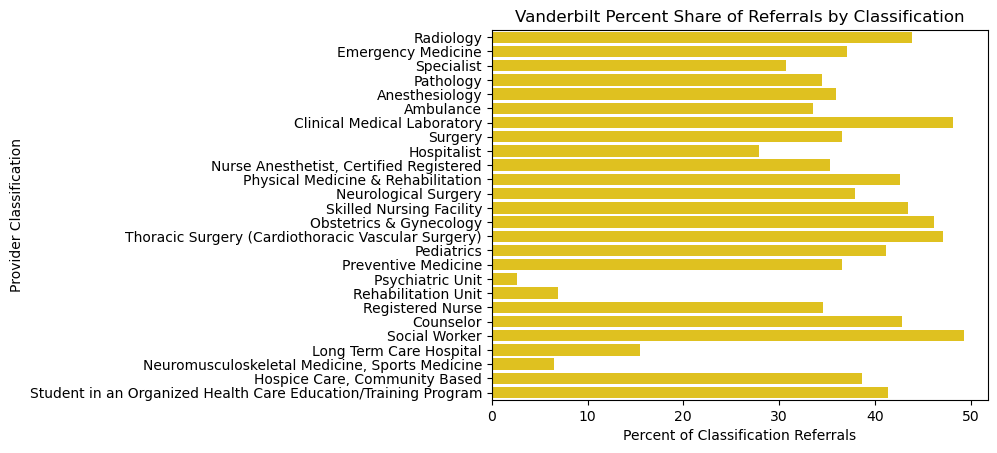

In [213]:
# set certain columns to different color if there's time to figure it out

# graph showing specialties to target
g = sns.barplot(y = 'provider_code_class',
            x = 'class_percent',
            data = vandy_target,
            color = 'gold')

g.set(xlabel = 'Percent of Classification Referrals')
g.set(ylabel = 'Provider Classification')
g.set(title = 'Vanderbilt Percent Share of Referrals by Classification')

plt.savefig('../plots/vandy_grow.png');

# specialist (because it's broad), physical med and rehab, ob/gyn, pediatrics, prev med, psych (they probably don't want this), long-term (they don't want it), hospice, sports med 

In [58]:
# find providers who send patients to more than just Vanderbilt - they already have a relationship with Vandy so the potential is there to persuade them to send more to Vandy and fewer to others

In [ ]:
# providers who send all patients to other hospitals